In [1]:
import pandas as pd
import numpy as np
import wfdb
import os
from tqdm import tqdm
import re 
from utils import get_arrythmia_path

/tmp/ipykernel_444129/105588533.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
dataset_path = "/cis/home/charr165/Downloads/ptb-xl"
info_df = pd.read_csv(os.path.join(dataset_path, "ptbxl_database.csv"))

In [3]:
records_path = os.path.join(dataset_path, 'records500')

record_paths_dict = {'rec_id': [], 'rec_path': []}

# List all folders in the records path
first_lvl_dirs = os.listdir(records_path)
first_lvl_dirs = [f for f in first_lvl_dirs if os.path.isdir(os.path.join(records_path, f))]

for first_lvl_dir in first_lvl_dirs:
    # Get all .hea files in the first level directory
    f_path = os.path.join(records_path, first_lvl_dir)
    files = os.listdir(f_path)
    hea_files = [f for f in files if f.endswith('.hea')]

    for f in hea_files:
        record_name = f.split('.')[0]
        record_paths_dict['rec_id'].append(record_name)
        record_paths_dict['rec_path'].append(os.path.join(records_path, first_lvl_dir, record_name))

records_path_df = pd.DataFrame(record_paths_dict)

print(f"Total number of records: {len(records_path_df)}")

Total number of records: 21799


In [4]:
info_df

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21794,21833,17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,...,True,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr
21795,21834,20703.0,300.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,...,True,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr
21796,21835,19311.0,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,...,True,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr
21797,21836,8873.0,64.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-09 18:21:49,...,True,NaN,NaN,NaN,NaN,SVES,NaN,8,records100/21000/21836_lr,records500/21000/21836_hr


In [6]:
unique_conditions = []

for code in info_df["scp_codes"]:
    keys = re.findall(r"'(.*?)'", code)
    for key in keys:
        if key not in unique_conditions:
            unique_conditions.append(key)

labels_df = pd.DataFrame(columns=['rec_id', 'wf'] + unique_conditions)

for index, row in tqdm(info_df.iterrows(), total=info_df.shape[0]):
    curr_baseline = os.path.basename(row['filename_hr'])
    curr_path = records_path_df[records_path_df['rec_id'] == curr_baseline]['rec_path'].values[0]

    record = wfdb.rdrecord(curr_path)
    wf = record.p_signal

    keys = re.findall(r"'(.*?)'", row['scp_codes'])

    for condition in unique_conditions:
        if condition in keys:
            labels_df.loc[index, condition] = 1
        else:
            labels_df.loc[index, condition] = 0

    labels_df.loc[index, 'rec_id'] = int(row['patient_id'])
    labels_df.loc[index, 'wf'] = wf


100%|██████████| 21799/21799 [08:03<00:00, 45.05it/s]


In [7]:
labels_df

,rec_id,wf,NORM,LVOLT,SR,SBRAD,IMI,ABQRS,SARRH,AFLT,...,3AVB,INJIL,2AVB,PRC(S),PSVT,PMI,STE_,WPW,INJIN,SVARR
0,15709,"[[-0.115, -0.05, 0.065, 0.082, -0.09, 0.007, -...",1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,13243,"[[-0.015, 0.12, 0.135, -0.053, -0.075, 0.127, ...",1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,20372,"[[-0.035, -0.07, -0.035, 0.053, 0.0, -0.052, 0...",1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,17014,"[[-0.055, -0.155, -0.1, 0.105, 0.023, -0.127, ...",1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,17448,"[[-0.04, -0.575, -0.535, 0.308, 0.248, -0.555,...",1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21794,17180,"[[-0.06, -0.03, 0.03, 0.045, -0.045, 0.0, 0.01...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21795,20703,"[[-0.035, 0.005, 0.04, 0.015, -0.038, 0.022, 0...",1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
21796,19311,"[[0.09, 0.08, -0.01, -0.085, 0.05, 0.035, 0.1,...",0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21797,8873,"[[-0.045, -0.035, 0.01, 0.04, -0.027, -0.012, ...",1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Iterate through final_df, and remove any records that have any nan in wf
nan_rows = []
for i, row in labels_df.iterrows():
    if np.isnan(row['wf']).any():
        nan_rows.append(i)

final_df = labels_df.drop(nan_rows)

print(f"Removed {len(nan_rows)} records with NaN values in wf")

final_df.head(5)

Removed 0 records with NaN values in wf


,rec_id,wf,NORM,LVOLT,SR,SBRAD,IMI,ABQRS,SARRH,AFLT,...,3AVB,INJIL,2AVB,PRC(S),PSVT,PMI,STE_,WPW,INJIN,SVARR
0,15709,"[[-0.115, -0.05, 0.065, 0.082, -0.09, 0.007, -...",1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,13243,"[[-0.015, 0.12, 0.135, -0.053, -0.075, 0.127, ...",1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,20372,"[[-0.035, -0.07, -0.035, 0.053, 0.0, -0.052, 0...",1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,17014,"[[-0.055, -0.155, -0.1, 0.105, 0.023, -0.127, ...",1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,17448,"[[-0.04, -0.575, -0.535, 0.308, 0.248, -0.555,...",1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# Save the final dataframe
os.makedirs('data', exist_ok=True)
final_df.to_pickle('data/ptb-xl_dataset.pickle')


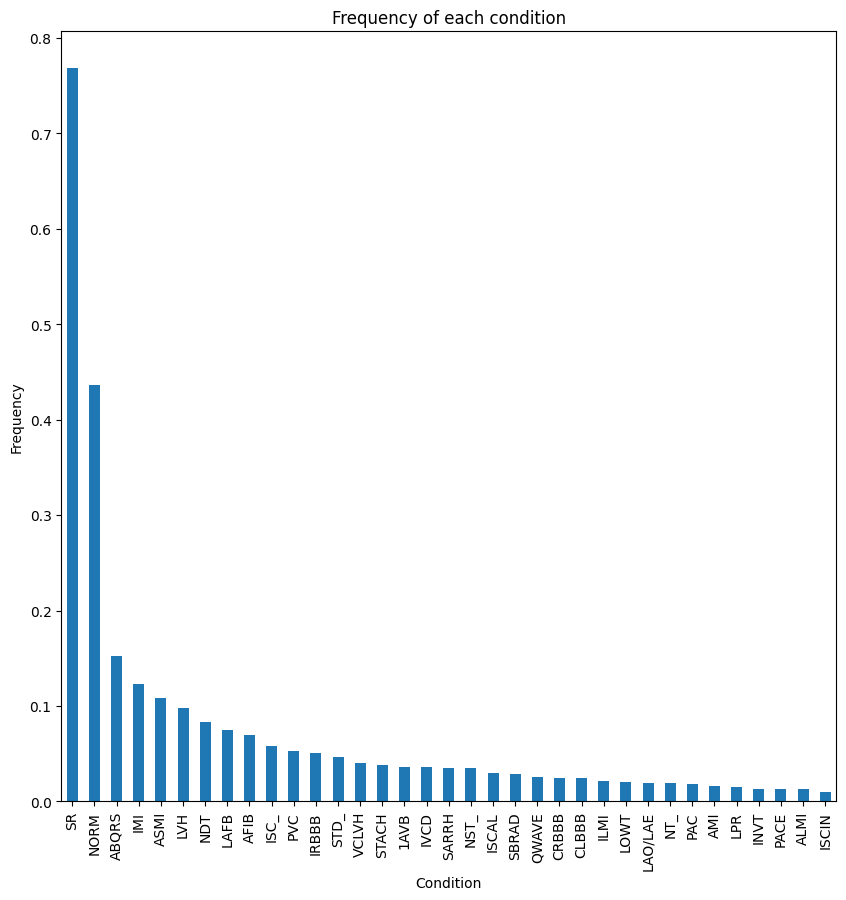

In [10]:
cols = labels_df.columns
cols = cols[2:]

# get the mean of each condition
mean = labels_df[cols].mean()
mean = mean[mean > 0.01]
# Sort the mean values
mean = mean.sort_values(ascending=False)

# Plot the mean of each condition
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
mean.plot(kind='bar')
plt.title('Frequency of each condition')
# Rotate the x labels
plt.xticks(rotation=90)
plt.xlabel('Condition')
plt.ylabel('Frequency')
plt.show()
